# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType 
from pyspark.sql.functions import desc, asc, datediff, to_date, lit, col
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.sql.functions import * 

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel,\
RandomForestClassifier, RandomForestClassificationModel,\
DecisionTreeClassifier, DecisionTreeClassificationModel,\
GBTClassifier, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.util import MLUtils

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Step 1 - Load the dataset

In [3]:
# load the mini-dataset json file into the user_log PySpark DataFrame
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
# display the Schema of the dataframe 
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Step 2 - Clean the dataset

In [5]:
# check the number of rows in the dataset
user_log.count()

286500

In [6]:
# check stats of the sessionId and userId field that have a numeric datatype
user_log.describe('sessionId', 'userId').show()

+-------+-----------------+-----------------+
|summary|        sessionId|           userId|
+-------+-----------------+-----------------+
|  count|           286500|           286500|
|   mean|1041.526554973822|59682.02278593872|
| stddev|726.7762634630741|109091.9499991047|
|    min|                1|                 |
|    max|             2474|               99|
+-------+-----------------+-----------------+



Notice that the min value for userId is empty.

In [7]:
# drop any null values in userId or sessionId
user_log_valid = user_log.dropna(how="any", subset = ["userId", "sessionId"])
user_log_valid.count()

286500

There are 286500 records in total and all the records have a userId and a sessionId, but some userIds are empty.

In [8]:
# select the userId column, remove duplicates and sort ascending
# check the values of the userId column of the dataframe
user_log_valid.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
# select the sessionId column, remove duplicates and sort ascending
# check the values of the sessionId column of the dataframe
# there aren't any blank values of sessionId
user_log_valid.select('sessionId').dropDuplicates().sort('sessionId').show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [10]:
# filter the pages that have been accessed by users with blank user id
blank_pages = user_log.filter(user_log.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

blank_pages.show()

+-------------------+
|        blank_pages|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



Based on the above analysis, there are records with blank values for the userId column but not for the sessionId. These records correspond to a subset of pages. It looks like these are users that haven't signed up in the platform yet or have signed up and are about to log in.

In [11]:
# keep only the records that don't have a blank userId
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')

In [12]:
print(f"There are {user_log_valid.count()} records with a valid userId in the clean dataset.")
print(f"These records correspond to {user_log_valid.select('userId').dropDuplicates().count()} unique users.")

There are 278154 records with a valid userId in the clean dataset.
These records correspond to 225 unique users.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Preliminary analysis

In [13]:
# select the page column, remove duplicates and sort ascending
# check the values of the page column of the dataframe
user_log_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



There seem to be following categories of page views or actions:  
1. Actions that are related to the usage of the platform:  
Add Friend, Add to Playlist, NextSong, Roll Advert, Thumbs Down, Thumbs Up
  
2. Actions that are related to navigating the platform, or managing settings:  
About, Help, Home, Save Settings, Settings, Logout

3. Actions that are related to downgrading or cancelling the user's subscription:  
Cancel, Cancellation Confirmation, Downgrade, Submit Downgrade

4. Actions that are related to upgrading the user's subscription:  
Submit Upgrade, Upgrade

5. Error page:  
Error


From the above actions the one that is definitely related to users downgrading is the `Cancellation Confirmation` that is the last step before quitting the platform.

In [14]:
# check some stats of the columns that have a numeric datatype
user_log_valid.describe('sessionId', 'userId', 'itemInSession', 'length', 'status').show()

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|         sessionId|           userId|     itemInSession|           length|            status|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|            278154|           278154|            278154|           228108|            278154|
|   mean|1042.5616241362698|59682.02278593872|114.89918174824018|249.1171819778458|209.10321620397335|
| stddev| 726.5010362219813|109091.9499991047|  129.851729399489|99.23517921058361|30.151388851328214|
|    min|                 1|               10|                 0|          0.78322|               200|
|    max|              2474|               99|              1321|       3024.66567|               404|
+-------+------------------+-----------------+------------------+-----------------+------------------+



In [15]:
# check the values of the status column
user_log_valid.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



The status column shows if a page action was valid or not (error-404).

In [16]:
# check the session related fields
#user_log_valid.select(["userId", "page", "sessionId", "itemInSession", "ts", "length"])\
#    .where(user_log.userId == "29")\
#    .orderBy('ts')\
#    .collect()

Each time a user accesses the platform the system logs a `sessionId` number, and for each page they access the system logs an `itemInSession` number that increases sequentially.

In [17]:
# check the values of the length column
check_length = user_log_valid.select('page', 'length') \
    .dropDuplicates()\
    .groupBy('page') \
    .sum()

check_length.show()

+--------------------+------------------+
|                page|       sum(length)|
+--------------------+------------------+
|              Cancel|              null|
|    Submit Downgrade|              null|
|         Thumbs Down|              null|
|                Home|              null|
|           Downgrade|              null|
|         Roll Advert|              null|
|              Logout|              null|
|       Save Settings|              null|
|Cancellation Conf...|              null|
|               About|              null|
|            Settings|              null|
|     Add to Playlist|              null|
|          Add Friend|              null|
|            NextSong|4351451.4320100015|
|           Thumbs Up|              null|
|                Help|              null|
|             Upgrade|              null|
|               Error|              null|
|      Submit Upgrade|              null|
+--------------------+------------------+



The `length` column is the time spent on each song - there is no length logged for any other type of action.

In [21]:
# check the total count for the string fields
user_log_valid.describe('auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'userAgent').show()

+-------+---------+---------+------+--------+------+-----------------+------+--------------------+
|summary|     auth|firstName|gender|lastName| level|         location|method|           userAgent|
+-------+---------+---------+------+--------+------+-----------------+------+--------------------+
|  count|   278154|   278154|278154|  278154|278154|           278154|278154|              278154|
|   mean|     null|     null|  null|    null|  null|             null|  null|                null|
| stddev|     null|     null|  null|    null|  null|             null|  null|                null|
|    min|Cancelled| Adelaida|     F|   Adams|  free|       Albany, OR|   GET|"Mozilla/5.0 (Mac...|
|    max|Logged In|   Zyonna|     M|  Wright|  paid|Winston-Salem, NC|   PUT|Mozilla/5.0 (comp...|
+-------+---------+---------+------+--------+------+-----------------+------+--------------------+



In [18]:
# check the values of the string columns
string_columns = ['auth', 'gender', 'level', 'method']
for each in string_columns:
    user_log_valid.select(each).dropDuplicates().sort(each).show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



### Define churn
We use the `Cancellation Confirmation` action to define churn, which happen for both paid and free users.

Churn is set to mark the actions before and including the cancellation action itself. In this way every record of a user that churned will be set to have churn = 1, not just the record with the cancellation action.

In [22]:
# create a function that flags the 'Cancellation Confirmation' records 
flag_cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# apply the function to the dataframe
# add a column churn to the dataframe to mark the records with a cancellation action
user_log_valid = user_log_valid.withColumn('churn', flag_cancellation_event('page'))

In [23]:
# partition by userId, order by timestamp in reverse order, get all rows before churn but no rows afterwards
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn('churn', Fsum('churn').over(windowval))

### Explore Data
Explore aggregates of users who stayed vs users who churned, in order to observe the behavior for users who stayed vs users who churned.

####  Explore users' level (free/paid) for users who stayed vs users who churned

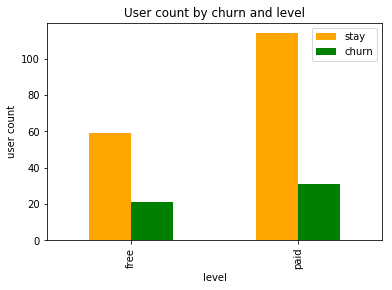

count    
churn     0   1
level          
free     59  21
paid    114  31

In [24]:
# Explore number of distinct users by level (number must sum to 225)
churn_by_level = user_log_valid.select('userId', 'level', 'churn') \
    .dropDuplicates(['userId']) \
    .groupby(['level', 'churn']) \
    .count()

# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_level_pd = churn_by_level.toPandas()
# use matplotlib to plot the results
churn_by_level_pd.pivot('level','churn').plot(kind='bar', color = ['orange', 'green'])
plt.legend(['stay', 'churn'])
plt.ylabel('user count')
plt.xlabel('level')
plt.title('User count by churn and level')
plt.show()

churn_by_level_pd.pivot('level','churn')

####  Explore users' gender (female/male) for users who stayed vs users who churned

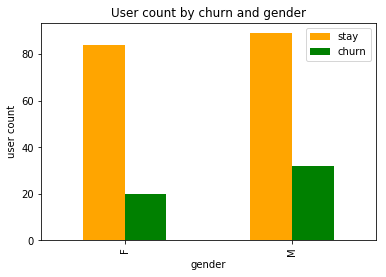

count    
churn      0   1
gender          
F         84  20
M         89  32

In [27]:
# Explore number of distinct users by gender (number must sum to 225)
churn_by_gender = user_log_valid.select('userId', 'gender', 'churn') \
    .dropDuplicates(['userId']) \
    .groupby(['gender', 'churn']) \
    .count()

# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_gender_pd = churn_by_gender.toPandas()

# use matplotlib to plot the results
churn_by_gender_pd.pivot('gender','churn').plot(kind='bar', color = ['orange', 'green'])
plt.legend(['stay', 'churn'])
plt.ylabel('user count')
plt.xlabel('gender')
plt.title('User count by churn and gender')
plt.show()

churn_by_gender_pd.pivot('gender','churn')

#### Explore the number of days since they registered for users that stayed vs users that churned

In [28]:
# source: https://sparkbyexamples.com/spark/spark-calculate-difference-between-two-dates-in-days-months-and-years/
# create a function that converts the epoch time to a datetime object and calculates the hour 
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
# add the registration date column in the dataframe
user_log_valid = user_log_valid.withColumn("reg_date", get_date(user_log_valid.registration))
# add the timestamp date column in the dataframe
user_log_valid = user_log_valid.withColumn("ts_date", get_date(user_log_valid.ts))
#calculate the difference between each ts and the registration date
user_log_valid = user_log_valid.withColumn("days_since_reg", datediff(col('ts_date'), col('reg_date')))

In [29]:
# calculate the maximum number of days since registration
churn_by_days_reg_per_user = user_log_valid.select('userId', 'days_since_reg', 'churn') \
                .groupby(['userId', 'churn']) \
                .agg(max('days_since_reg').alias('max_days_since_reg'))

churn_by_days_reg = churn_by_days_reg_per_user.groupby(['churn','max_days_since_reg'])\
                .count()\
                .orderBy('churn', 'max_days_since_reg')
                
# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_days_reg_pd = churn_by_days_reg.toPandas()

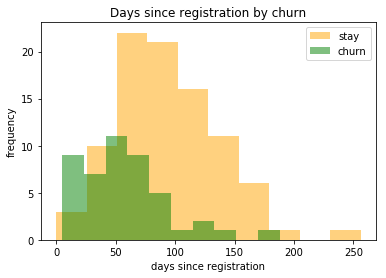

In [30]:
#source: https://www.statology.org/pandas-histogram-by-group/
#define max_days_since_reg values by group
A = churn_by_days_reg_pd.loc[churn_by_days_reg_pd['churn'] == 0, 'max_days_since_reg']
B = churn_by_days_reg_pd.loc[churn_by_days_reg_pd['churn'] == 1, 'max_days_since_reg']

#add two histograms to one plot
plt.hist(A, alpha=0.5, label='stay', color = 'orange')
plt.hist(B, alpha=0.5, label='churn', color = 'green')

#add plot title and axis labels
plt.title('Days since registration by churn')
plt.xlabel('days since registration')
plt.ylabel('frequency')

#add legend
plt.legend()

#display plot
plt.show()

#### Explore number of songs played per day for users that stayed vs users that churned

In [31]:
# source: https://pynative.com/python-get-the-day-of-week/#:~:text=We%20can%20use%20the%20weekday,%2C%2002)%20is%20a%20Monday.
# create a function that converts the epoch time to a datetime object and calculates the day name and number 
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%a'))
get_day_num = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

# add the day column in the dataframe
user_log_valid = user_log_valid.withColumn("day", get_day(user_log_valid.ts))
user_log_valid = user_log_valid.withColumn("day_num", get_day_num(user_log_valid.ts))

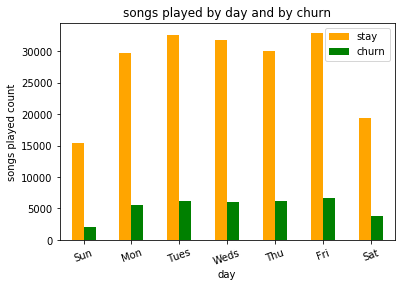

In [32]:
# calculate the number of songs played per day of the week by churn
churn_by_songs_in_day = user_log_valid.filter(user_log_valid.page == "NextSong")\
                .groupby([user_log_valid.day_num, user_log_valid.churn]).count() \
                .orderBy(user_log_valid.day_num, user_log_valid.churn)

# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_songs_in_day_pd = churn_by_songs_in_day.toPandas()
churn_by_songs_in_day_pd.day_num = pd.to_numeric(churn_by_songs_in_day_pd.day_num)
churn_by_songs_in_day_pd.pivot('churn', 'day_num')

# use matplotlib to plot the results
churn_by_songs_in_day_pd.pivot('day_num','churn').plot(kind='bar', color = ['orange', 'green'])
plt.legend(['stay', 'churn'])
plt.ylabel('songs played count')
plt.xlabel('day')
plt.title('songs played by day and by churn')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Sun', 'Mon', 'Tues', 'Weds', 'Thu', 'Fri', 'Sat'], rotation=20) 
plt.show()

#### Explore number of songs played per hour for users that stayed vs users that churned

In [33]:
# create a function that converts the epoch time to a datetime object and calculates the hour 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
# add the hour column in the dataframe
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log_valid.ts))

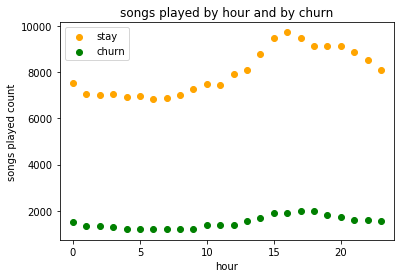

In [34]:
# calculate the number of songs played per hour by churn
churn_by_songs_in_hour = user_log_valid.filter(user_log_valid.page == "NextSong")\
                .groupby([user_log_valid.hour, user_log_valid.churn]).count() \
                .orderBy(user_log_valid.hour.cast("float"), user_log_valid.churn)

# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_songs_in_hour_pd = churn_by_songs_in_hour.toPandas()
churn_by_songs_in_hour_pd.hour = pd.to_numeric(churn_by_songs_in_hour_pd.hour)

churn_0 = churn_by_songs_in_hour_pd[churn_by_songs_in_hour_pd['churn'] == 0]
churn_0.reset_index(drop=True, inplace = True)
churn_1 = churn_by_songs_in_hour_pd[churn_by_songs_in_hour_pd['churn'] == 1]
churn_1.reset_index(drop=True, inplace = True)

# use matplotlib to plot the results
plt.scatter(churn_0['hour'], churn_0['count'], color = "orange")
plt.scatter(churn_0['hour'], churn_1['count'], color = "green")
plt.legend(['stay', 'churn'])
plt.xlim(-1, 24)
plt.xlabel("hour")
plt.ylabel("songs played count")
plt.title('songs played by hour and by churn');

#### Explore the number of page visits (actions) for the users that stayed vs the users that churned

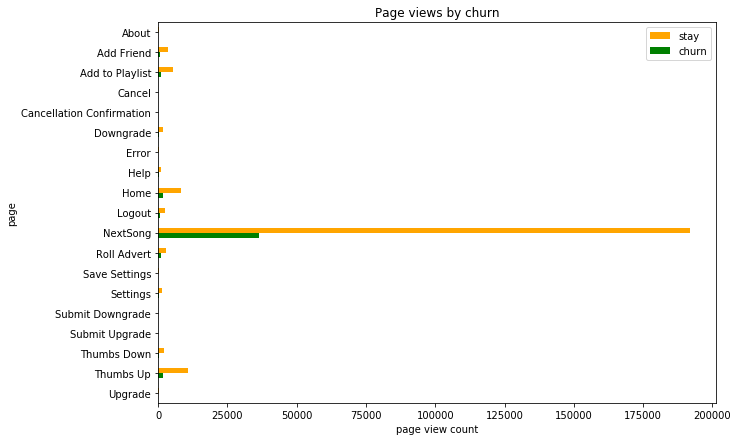

In [35]:
# Explore number of page visits
churn_by_page_visits = user_log_valid.select('page', 'churn') \
    .groupby(['page', 'churn']).count() \
    .orderBy(user_log_valid.page, user_log_valid.churn)

# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_page_visits_pd = churn_by_page_visits.toPandas()
churn_by_page_visits_pd.pivot('churn','page')

# use matplotlib to plot the results
churn_by_page_visits_pd.pivot('page','churn').plot(kind='barh', color = ['orange', 'green'], figsize=(10,7))
plt.legend(['stay', 'churn'])
plt.xlabel('page view count')
plt.ylabel('page')
plt.title('Page views by churn')
plt.gca().invert_yaxis()
plt.show()

#### Explore the number of key page visits (actions that are related to usage) for the users that stayed vs the users that churned

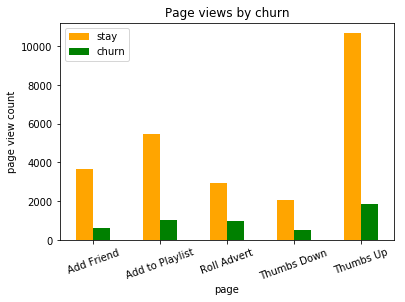

In [36]:
# Explore number of key page visits
key_pages = ['Thumbs Up', 'Thumbs Down', 'Add Friend', 'Add to Playlist', 'Roll Advert']
churn_by_key_page_visits = user_log_valid.select('userId', 'page', 'churn') \
    .filter(user_log_valid.page.isin(key_pages)) \
    .groupby(['page', 'churn']).count() \
    .orderBy(user_log_valid.page, user_log_valid.churn)

# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_key_page_visits_pd = churn_by_key_page_visits.toPandas()
churn_by_key_page_visits_pd.pivot('churn','page')

# use matplotlib to plot the results
churn_by_key_page_visits_pd.pivot('page','churn').plot(kind='bar', color = ['orange', 'green'])
plt.legend(['stay', 'churn'])
plt.ylabel('page view count')
plt.xlabel('page')
plt.title('Page views by churn')
plt.xticks(rotation=20)
plt.show()

#### Explore the ratio of key page visits (actions) per number of songs played, for users that stayed vs users that churned

In [37]:
# create a function to flag each key action 
flag_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
flag_thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
flag_thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
flag_add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
flag_add_to_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
flag_roll_advert = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())


# add a column that flags if a record is related to a key action
user_log_valid = user_log_valid.withColumn("song_page", flag_song(user_log_valid.page))
user_log_valid = user_log_valid.withColumn("thumbs_up", flag_thumbs_up(user_log_valid.page))
user_log_valid = user_log_valid.withColumn("thumbs_down", flag_thumbs_down(user_log_valid.page))
user_log_valid = user_log_valid.withColumn("add_friend", flag_add_friend(user_log_valid.page))
user_log_valid = user_log_valid.withColumn("add_to_playlist", flag_add_to_playlist(user_log_valid.page))
user_log_valid = user_log_valid.withColumn("roll_advert", flag_add_to_playlist(user_log_valid.page))

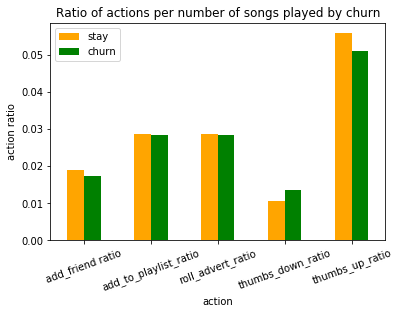

In [38]:
# calculate the ratio of number each action per number of songs played
churn_by_actions_per_song = user_log_valid.select('churn', 'song', 'thumbs_up', 'thumbs_down', 'add_friend', 'add_to_playlist', 'roll_advert' ) \
                .groupby('churn') \
                .agg(count('song').alias('num_songs'),\
                     (sum('add_friend')/count('song')).alias('add_friend ratio'),\
                     (sum('add_to_playlist')/count('song')).alias('add_to_playlist_ratio'),\
                     (sum('roll_advert')/count('song')).alias('roll_advert_ratio'),\
                     (sum('thumbs_down')/count('song')).alias('thumbs_down_ratio'),\
                     (sum('thumbs_up')/count('song')).alias('thumbs_up_ratio'))
                     
# turn the PySpark dataframe to a pandas dataframe to visualise the results
churn_by_actions_per_song_pd = churn_by_actions_per_song.toPandas().transpose()
churn_by_actions_per_song_pd = churn_by_actions_per_song_pd.drop(['churn','num_songs'])

# use matplotlib to plot the results
churn_by_actions_per_song_pd.plot(kind='bar', color = ['orange', 'green'])
plt.legend(['stay', 'churn'])
plt.xlabel('action')
plt.ylabel('action ratio')
plt.title('Ratio of actions per number of songs played by churn')
plt.xticks(rotation=20) #['Add Friend Ratio', 'Add to Playlist Ratio', 'Roll Advert Ratio', 'Thumbs Down Ratio', 'Thumbs Up Ratio'],
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [39]:
# source https://stackoverflow.com/questions/61349294/get-row-corresponding-to-latest-timestamp-in-pyspark
# Calculate the latest record per user and get the churn, level and gender

user_window = Window.partitionBy('userID').orderBy(col('ts').desc())

latest_status = user_log_valid.select('userId','churn','level', 'gender', 'ts')\
                .withColumn('rn', row_number().over(user_window))\
                .filter(col('rn') == 1)\
                .drop('rn')\
                .drop('ts')

latest_status = latest_status.withColumn("gender_num", \
                when(col("gender")=='M', 0)\
                .when(col("gender")=='F', 1).otherwise(0)) 


latest_status = latest_status.withColumn("level_num", \
                       when(col("level")=='free', 0)\
                       .when(col("level")=='paid', 1).otherwise(0))

latest_status.show(5)
print(f"There are {latest_status.count()} rows.")

+------+-----+-----+------+----------+---------+
|userId|churn|level|gender|gender_num|level_num|
+------+-----+-----+------+----------+---------+
|100010|    0| free|     F|         1|        0|
|200002|    0| paid|     M|         0|        1|
|   125|    1| free|     M|         0|        0|
|   124|    0| paid|     F|         1|        1|
|    51|    1| paid|     M|         0|        1|
+------+-----+-----+------+----------+---------+
only showing top 5 rows

There are 225 rows.


In [40]:
# Calculate the number of unique artists, unique songs, total length of songs played, total pages viewed
usage = user_log_valid.select('userId', 'artist', 'song', 'length', 'page') \
    .groupby('userId') \
    .agg(countDistinct('artist').alias('unique_artists'),\
         countDistinct('song').alias('unique_songs'),\
         sum('length').alias('total_length'), \
         count('page').alias('total_pages'))

usage.show(5)
print(f"There are {usage.count()} rows.")

+------+--------------+------------+------------------+-----------+
|userId|unique_artists|unique_songs|      total_length|total_pages|
+------+--------------+------------+------------------+-----------+
|100010|           252|         269| 66940.89735000003|        381|
|200002|           339|         378| 94008.87593999993|        474|
|   125|             8|           8|2089.1131000000005|         11|
|    51|          1385|        1854| 523275.8428000004|       2464|
|   124|          2232|        3339|1012312.0927899999|       4825|
+------+--------------+------------+------------------+-----------+
only showing top 5 rows

There are 225 rows.


In [41]:
# Calculate the number of sessions, and the avg number of actions per session
sessions = user_log_valid.select('userId', 'sessionId', 'itemInSession', 'song') \
    .groupby('userId') \
    .agg(countDistinct('sessionId').alias('total_sessions'),\
         (count('itemInSession')/countDistinct('sessionId')).alias('avg_itemsInSession'),\
         (count('song')/countDistinct('sessionId')).alias('avg_songsInSession'))

sessions.show(5)
print(f"There are {sessions.count()} rows.")

+------+--------------+------------------+------------------+
|userId|total_sessions|avg_itemsInSession|avg_songsInSession|
+------+--------------+------------------+------------------+
|100010|             7| 54.42857142857143|39.285714285714285|
|200002|             6|              79.0|              64.5|
|   125|             1|              11.0|               8.0|
|    51|            10|             246.4|             211.1|
|   124|            29| 166.3793103448276| 140.6551724137931|
+------+--------------+------------------+------------------+
only showing top 5 rows

There are 225 rows.


In [43]:
#check for a specific user
#user_log_valid.select(['userId', 'page', 'artist', 'song'])\
#                .where(user_log_valid.userId=='125').sort('page').collect()

In [44]:
# Calculate the number of days between the registration and the last user action 
days_since_registration = user_log_valid.select('userId', 'days_since_reg') \
                .groupby(['userId']) \
                .agg(max('days_since_reg').alias('max_days_since_reg'))

days_since_registration.show(5)
print(f"There are {days_since_registration.count()} rows.")

+------+------------------+
|userId|max_days_since_reg|
+------+------------------+
|100010|                55|
|200002|                70|
|   125|                72|
|    51|                20|
|   124|               131|
+------+------------------+
only showing top 5 rows

There are 225 rows.


In [45]:
# check for a specific user
#user_log_valid.select(['userId','ts_date', 'reg_date', 'days_since_reg'])\
#                .where(user_log_valid.userId=='125').sort(col('days_since_reg').desc()).collect()

In [47]:
# Calculate the average number of songs played per day per user

# number of songs per day
songs_per_day = user_log_valid.filter(user_log_valid.page == "NextSong")\
                .groupby(['userId', 'day_num']) \
                .count() \
                .orderBy('userId', user_log_valid.day_num.cast("float"))


# calculate the average songs per day per user
avg_songs_per_day = songs_per_day.groupby('userId')\
                    .agg(avg('count')\
                    .alias('avg_songs_per_day'))\
                    .orderBy('userId')

avg_songs_per_day.show(5)
print(f"There are {avg_songs_per_day.count()} rows.")

+------+------------------+
|userId| avg_songs_per_day|
+------+------------------+
|    10|            168.25|
|   100|383.14285714285717|
|100001|              66.5|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows

There are 225 rows.


In [46]:
# Calculate the average number of songs played per hour per user

# number of songs played per hour per user
songs_per_hour = user_log_valid.filter(user_log_valid.page == "NextSong")\
                .groupby(['userId', 'hour']) \
                .count() \
                .orderBy('userId', user_log_valid.hour.cast("float"))


# calculate the average songs per hour per user
avg_songs_per_hour = songs_per_hour.groupby('userId')\
                    .agg(avg('count').alias('avg_songs_per_hour'))\
                    .orderBy('userId')

avg_songs_per_hour.show(5)
print(f"There are {avg_songs_per_hour.count()} rows.")

+------+------------------+
|userId|avg_songs_per_hour|
+------+------------------+
|    10|28.041666666666668|
|   100|            111.75|
|100001|11.083333333333334|
|100002|              15.0|
|100003|             12.75|
+------+------------------+
only showing top 5 rows

There are 225 rows.


In [48]:
# Calculate the ratio of number each action per number of songs played
actions_songs_ratio = user_log_valid.select('userId', 'song', 'thumbs_up', 'thumbs_down', 'add_friend', 'add_to_playlist', 'roll_advert' ) \
                .groupby('userId') \
                .agg(count('song').alias('num_songs'),\
                     sum('thumbs_up').alias('num_thumbs_up'),\
                     sum('thumbs_down').alias('num_thumbs_down'),\
                     sum('add_friend').alias('num_add_friend'),\
                     sum('add_to_playlist').alias('num_add_to_playlist'),\
                     sum('roll_advert').alias('num_roll_advert'))\
                .withColumn('thumbs_up_ratio', (col('num_thumbs_up') / col('num_songs')))\
                .withColumn('thumbs_down_ratio', (col('num_thumbs_down') / col('num_songs')))\
                .withColumn('add_friend_ratio', (col('num_add_friend') / col('num_songs')))\
                .withColumn('add_to_playlist_ratio', (col('num_add_to_playlist') / col('num_songs')))\
                .withColumn('roll_advert_ratio', (col('num_roll_advert') / col('num_songs')))\
                .orderBy('userId')

print(f"There are {actions_songs_ratio.count()} rows.")
actions_songs_ratio.head()

There are 225 rows.


Row(userId='10', num_songs=673, num_thumbs_up=37, num_thumbs_down=4, num_add_friend=12, num_add_to_playlist=9, num_roll_advert=9, thumbs_up_ratio=0.0549777117384844, thumbs_down_ratio=0.005943536404160475, add_friend_ratio=0.017830609212481426, add_to_playlist_ratio=0.01337295690936107, roll_advert_ratio=0.01337295690936107)

In [49]:
# source: https://sparkbyexamples.com/pyspark/pyspark-join-two-or-multiple-dataframes/
#Join Multiple DataFrames to form the dataframe for the label and features
label_features = latest_status.join(usage , ['userId']) \
                .join(sessions, ['userId']) \
                .join(days_since_registration, ['userId']) \
                .join(avg_songs_per_hour, ['userId']) \
                .join(avg_songs_per_day, ['userId']) \
                .join(actions_songs_ratio, ['userId'])

print(f"There are {label_features.count()} rows.")
label_features.head()

There are 225 rows.


Row(userId='100010', churn=0, level='free', gender='F', gender_num=1, level_num=0, unique_artists=252, unique_songs=269, total_length=66940.89735000003, total_pages=381, total_sessions=7, avg_itemsInSession=54.42857142857143, avg_songsInSession=39.285714285714285, max_days_since_reg=55, avg_songs_per_hour=16.176470588235293, avg_songs_per_day=55.0, num_songs=275, num_thumbs_up=17, num_thumbs_down=5, num_add_friend=4, num_add_to_playlist=7, num_roll_advert=7, thumbs_up_ratio=0.06181818181818182, thumbs_down_ratio=0.01818181818181818, add_friend_ratio=0.014545454545454545, add_to_playlist_ratio=0.025454545454545455, roll_advert_ratio=0.025454545454545455)

In [50]:
# rename churn to label and remove any columns we don't need
ml_data = label_features.withColumnRenamed('churn','label').drop('userId','level', 'gender')

# check the datatype of all the columns of the dataset for the machine learning modeling
ml_data.printSchema()

root
 |-- label: long (nullable = true)
 |-- gender_num: integer (nullable = false)
 |-- level_num: integer (nullable = false)
 |-- unique_artists: long (nullable = false)
 |-- unique_songs: long (nullable = false)
 |-- total_length: double (nullable = true)
 |-- total_pages: long (nullable = false)
 |-- total_sessions: long (nullable = false)
 |-- avg_itemsInSession: double (nullable = true)
 |-- avg_songsInSession: double (nullable = true)
 |-- max_days_since_reg: integer (nullable = true)
 |-- avg_songs_per_hour: double (nullable = true)
 |-- avg_songs_per_day: double (nullable = true)
 |-- num_songs: long (nullable = false)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_add_friend: long (nullable = true)
 |-- num_add_to_playlist: long (nullable = true)
 |-- num_roll_advert: long (nullable = true)
 |-- thumbs_up_ratio: double (nullable = true)
 |-- thumbs_down_ratio: double (nullable = true)
 |-- add_friend_ratio: double (nullable = 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [103]:
# check the label and features colums
label = ml_data.columns[0]
print(f"label: {label}")
features = ml_data.columns[1:]
print(f"features: {features}")

label: label
features: ['gender_num', 'level_num', 'unique_artists', 'unique_songs', 'total_length', 'total_pages', 'total_sessions', 'avg_itemsInSession', 'avg_songsInSession', 'max_days_since_reg', 'avg_songs_per_hour', 'avg_songs_per_day', 'num_songs', 'num_thumbs_up', 'num_thumbs_down', 'num_add_friend', 'num_add_to_playlist', 'num_roll_advert', 'thumbs_up_ratio', 'thumbs_down_ratio', 'add_friend_ratio', 'add_to_playlist_ratio', 'roll_advert_ratio']


In [104]:
def build_model_cv(model, paramGrid, features, data):
    '''
    Builds a classification model using a pipeline with the following stages:
    1) VectorAssembler, to generate a vector with all the numeric features
    2) StandardScaler, to scale the numeric features
    3) model, a classification algorithm
    It performs hyperparameter tuning using 3-fold cross validation with a 
    parameter grid to test different parameters to optimize the model.
    It uses a MulticlassClassificationEvaluator evaluator to produce evaluation metrics.
    
    INPUT 
    model - a classification model
    paramGrid - a set of hyperparameters to test the model with
    features - a list with the columns that are used for the features
    data - the dataframe with the label and the features
        
    OUTPUT
    crossval - a cross validated classification model
    '''    
    print("Building model...")
    # set up the pipeline
    assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features', withStd=True, withMean=True)
    pipeline = Pipeline(stages=[assembler, scaler, model])
    
    # set up the cross validation
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    print("Building model complete.")

    return crossval

In [105]:
def train_model_cv(model, data):
    '''
    Trains a classification model.
    
    INPUT 
    model - a classification model
    data - the dataframe with the label and the features used for training
        
    OUTPUT
    cvModel - a trained classification model
    '''
    
    print("Training model...")
    trained_model = model.fit(data)
    print("Training model complete.")
    
    return trained_model

In [106]:
# source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
# source: https://stackoverflow.com/questions/64090386/get-all-evaluation-metrics-after-classification-in-pyspark
def evaluate_model(model, data, case):
    '''
    Prints out a set of evaluation metrics (accuracy, f1-score, presision, recall) and
    returns the predictions.
    
    INPUT 
    cvModel - a trained classification model
    data - the dataframe with the label and the features used for validation
    case - states the algorithm and if the evaluation is done on test or validation data
        
    OUTPUT
    preds - a dataset with the predictions
    metrics - a dataset with the evaluated metrics
    '''
    
    print("Evaluating model...")
    preds = model.transform(data)
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    
    accuracy = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
    f1_score = evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    precision = evaluator.evaluate(preds, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(preds, {evaluator.metricName: "weightedRecall"})
    
    metrics = pd.DataFrame([[case, accuracy,f1_score,precision,recall]],columns=['case','accuracy','f1_score','precision','recall'])
    
    print("Evaluating model complete.")
    
    return preds, metrics

In [107]:
# Split the data into train (80%), test (20%)
train, test = ml_data.randomSplit([0.8, 0.2], seed=42)

# Split the data into train (60%), rest (40%)
#train, rest = ml_data.randomSplit([0.6, 0.4], seed=42)

# Split the rest data into test (20%), validation (20%)
#test, validation = rest.randomSplit([0.5, 0.5], seed=42)

#### 1 -  Logistic Regression 

In [108]:
# set up the classification model
lr_model = LogisticRegression(maxIter=10, elasticNetParam=0, featuresCol="features", labelCol="label")

# set up the parameter grid
lr_paramGrid = ParamGridBuilder()\
            .addGrid(lr_model.regParam,[0.0, 0.1])\
            .build()

# build the cross validation model
lr_crossval = build_model_cv(lr_model, lr_paramGrid, features, ml_data)

# train the model
lr_cvModel = train_model_cv(lr_crossval, train)

Building model...
Building model complete.
Training model...
Training model complete.


In [109]:
# evaluate the model using the train data
lr_trainpreds, lr_trainmetrics = evaluate_model(lr_cvModel, train, 'lr-train')

lr_trainmetrics

Evaluating model...
Evaluating model complete.


,case,accuracy,f1_score,precision,recall
0,lr-train,0.816754,0.788772,0.79903,0.816754


#### 2 - Random Forest Classifier

In [110]:
# set up the classification model
rf_model = RandomForestClassifier(featuresCol="features", labelCol="label")

# set up the parameter grid
rf_paramGrid = ParamGridBuilder()\
            .addGrid(rf_model.maxDepth,[10, 20])\
            .addGrid(rf_model.numTrees,[10, 20])\
            .build()

# build the cross validation model
rf_crossval = build_model_cv(rf_model, rf_paramGrid, features, ml_data)

# train the model
rf_cvModel = train_model_cv(rf_crossval, train)

Building model...
Building model complete.
Training model...
Training model complete.


In [111]:
# evaluate the model using the train data
rf_trainpreds, rf_trainmetrics = evaluate_model(rf_cvModel, train, 'rf-train')

rf_trainmetrics

Evaluating model...
Evaluating model complete.


,case,accuracy,f1_score,precision,recall
0,rf-train,0.973822,0.97321,0.974672,0.973822


#### 3 - Decision Tree Classifier

In [117]:
# set up the classification model
dt_model = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# set up the parameter grid
dt_paramGrid = ParamGridBuilder()\
            .addGrid(dt_model.maxDepth,[5,10,20])\
            .build()

# build the cross validation model
dt_crossval = build_model_cv(dt_model, dt_paramGrid, features, ml_data)

# train the model
dt_cvModel = train_model_cv(dt_crossval, train)

Building model...
Building model complete.
Training model...
Training model complete.


In [118]:
# evaluate the model using the train data
dt_trainpreds, dt_trainmetrics = evaluate_model(dt_cvModel, train, 'dt-train')

dt_trainmetrics

Evaluating model...
Evaluating model complete.


,case,accuracy,f1_score,precision,recall
0,dt-train,0.931937,0.929624,0.931145,0.931937


#### Compare between the models

After comparing the accuracy we get when we use the test data, logistic regression is the winning model.

In [119]:
compare = pd.concat([lr_trainmetrics, rf_trainmetrics, dt_trainmetrics])#, gbt_testmetrics])
compare

,case,accuracy,f1_score,precision,recall
0,lr-train,0.816754,0.788772,0.799030,0.816754
0,rf-train,0.973822,0.973210,0.974672,0.973822
0,dt-train,0.931937,0.929624,0.931145,0.931937


####  Report the results of the winning model on the test data

In [120]:
# source: https://haya-toumy.gitbook.io/spark-notes/pyspark/pyspark/random-forest-classifier-example
def get_features_importances(model, features, cl):
    '''
    Returns a dataset with the importance of each feature sorted in descending order.
    
    INPUT 
    model - a trained classification model
    features - a list with the columns that are used for the features
    cl - a shortcut for the algorithm that is being used
        
    OUTPUT
    importances_df - a dataset with the importance of each feature
    '''
    
    if cl == 'lr':
        coef_vals = model.coefficients.values.tolist()
        importances_df= pd.DataFrame(list(zip(features, coef_vals)), columns=['feature', 'coefficient'])\
                        .sort_values('coefficient', ascending=False)        
    else:
        vals = model.featureImportances.values.tolist()
        importances_df= pd.DataFrame(list(zip(features, vals)), columns=['feature', 'value'])\
                        .sort_values('value', ascending=False)   
        
    
    return importances_df

In [121]:
#source: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_features_importances(x_data, y_data):
    '''
    Plots a horizontal barplot using the given dataset with the features importance.
    
    INPUT 
    x_data - The data for the x-axis (importance)
    y_data - The data for the y-axis (feature)
    '''

    # define size of bar plot
    plt.figure(figsize=(10,8))
    # plot Searborn bar chart
    sns.barplot(x=x_data, y=y_data)
    # add chart labels
    plt.title('Importance of features')
    plt.xlabel('importance')
    plt.ylabel('feature');

In [122]:
# evaluate the model using the test data
rf_testpreds, rf_testmetrics = evaluate_model(rf_cvModel, test, 'rf-test')

# present the metrics for the test and validation data
final_metrics = pd.concat([rf_testmetrics, rf_trainmetrics])
final_metrics

Evaluating model...
Evaluating model complete.


,case,accuracy,f1_score,precision,recall
0,rf-test,0.764706,0.727358,0.761765,0.764706
0,rf-train,0.973822,0.973210,0.974672,0.973822


In [128]:
# source: https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark

# get the best model from the cross validation
rf_bestmodel = rf_cvModel.bestModel.stages[2]

# save the best model
rf_bestmodel.write().overwrite().save("rf_bestmodel")

# load model
rf_bestmodel = RandomForestClassificationModel.load("rf_bestmodel")

# get the best parameters
bestparams = rf_bestmodel._java_obj.extractParamMap()
print(f"Best parameters: {bestparams}")

Best parameters: {
	RandomForestClassifier_bca3f67ba22e-cacheNodeIds: false,
	RandomForestClassifier_bca3f67ba22e-checkpointInterval: 10,
	RandomForestClassifier_bca3f67ba22e-featureSubsetStrategy: auto,
	RandomForestClassifier_bca3f67ba22e-featuresCol: features,
	RandomForestClassifier_bca3f67ba22e-impurity: gini,
	RandomForestClassifier_bca3f67ba22e-labelCol: label,
	RandomForestClassifier_bca3f67ba22e-maxBins: 32,
	RandomForestClassifier_bca3f67ba22e-maxDepth: 10,
	RandomForestClassifier_bca3f67ba22e-maxMemoryInMB: 256,
	RandomForestClassifier_bca3f67ba22e-minInfoGain: 0.0,
	RandomForestClassifier_bca3f67ba22e-minInstancesPerNode: 1,
	RandomForestClassifier_bca3f67ba22e-numTrees: 10,
	RandomForestClassifier_bca3f67ba22e-predictionCol: prediction,
	RandomForestClassifier_bca3f67ba22e-probabilityCol: probability,
	RandomForestClassifier_bca3f67ba22e-rawPredictionCol: rawPrediction,
	RandomForestClassifier_bca3f67ba22e-seed: 4838954316873299963,
	RandomForestClassifier_bca3f67ba22e-sub

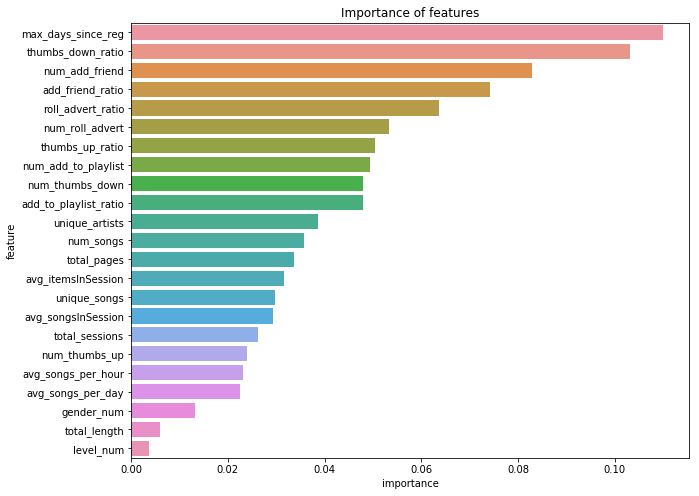

In [129]:
# get features importance
rf_importance_df = get_features_importances(rf_bestmodel, features, 'rf')

# plot features importance
plot_features_importances(rf_importance_df['value'], rf_importance_df['feature'])

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.